In [1]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

In [2]:
# Define directories
ai_directory = 'data/AI Codes'
human_directory = 'data/Human Codes'

In [3]:
# Function to load code snippets from a directory and label them
def load_code_snippets(directory, label):
    snippets = []
    for filename in os.listdir(directory):
        if filename.endswith('.py'):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                code = file.read()
                if code.strip():  # Ensure non-empty content
                    snippets.append((code, label))
    return snippets

# Load datasets
ai_snippets = load_code_snippets(ai_directory, 'AI')
human_snippets = load_code_snippets(human_directory, 'Human')

# show the number of code snippets in each dataset
print('Number of AI code snippets:', len(ai_snippets))
print('Number of human code snippets:', len(human_snippets))


Number of AI code snippets: 200
Number of human code snippets: 200


In [4]:
# Combine the datasets
data = ai_snippets + human_snippets

In [5]:
# Convert them to dataframe
data = pd.DataFrame(data, columns=['code', 'label'])

#show data
print(data.head())


                                                code label
0  import requests\nfrom bs4 import BeautifulSoup...    AI
1  def bucket_sort(arr):\n    bucket = [[] for _ ...    AI
2  import random\n\ndef guess_number():\n    numb...    AI
3  def binary_search(arr, target):\n    left, rig...    AI
4  def convert_length(meters):\n    return meters...    AI


In [6]:
# Data preparation
def clean_code(code):
    # Remove comments
    code = re.sub(r'#.*', '', code)
    # Remove unnecessary whitespaces
    code = ' '.join(code.split())
    # If there is at least something in the code return it else return ' '
    return code if len(code) > 0 else ' '

# Clean the collected codes
data['code'] = data['code'].apply(clean_code)

In [7]:
# Convert labels to numeric
data['label'] = np.where(data['label'] == 'Human', 0, 1)

## Feature Engineering

Shape of X_bow: (400, 5826)

Word Counts:

     word  count
0      00      3
1     000      1
2  000000      1
3     001      1
4    0066      1

Top 10 Most Common Words:

        word  count
4552    self   1451
3970   print   1243
1445     def   1005
2519      if    927
2579      in    662
2570  import    563
2622   input    552
2066     for    551
4339  return    500
1739   enter    456


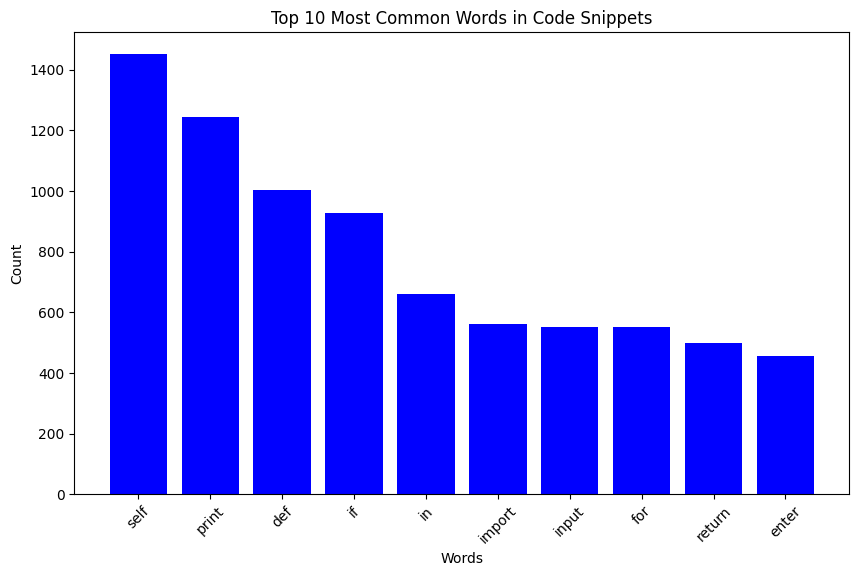

In [8]:
# Bag of Words transformation
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['code'])


#---------------------------------------------------#
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Display the shape of the transformed data
print("Shape of X_bow:", X_bow.shape)

# Get the feature names (words)
feature_names = bow_vectorizer.get_feature_names_out()

# Sum the occurrences of each word in the corpus
word_counts = np.asarray(X_bow.sum(axis=0)).flatten()

# Create a DataFrame for the word counts
word_count_df = pd.DataFrame({'word': feature_names, 'count': word_counts})

# Display the first few rows of the word count DataFrame
print("\nWord Counts:\n")
print(word_count_df.head())

# Sort the DataFrame by count in descending order
word_count_df = word_count_df.sort_values(by='count', ascending=False)

# Display the top 10 most common words
print("\nTop 10 Most Common Words:\n")
print(word_count_df.head(10))

# Plot the top 10 most common words
plt.figure(figsize=(10, 6))
plt.bar(word_count_df['word'].head(10), word_count_df['count'].head(10), color='blue')
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 10 Most Common Words in Code Snippets')
plt.xticks(rotation=45)
plt.show()


Shape of X_tfidf: (400, 5826)

TF-IDF Scores:

     word     score
0      00  0.110200
1     000  0.005212
2  000000  0.044384
3     001  0.111298
4    0066  0.058724

Top 10 Words with Highest TF-IDF Scores:

        word      score
3970   print  25.250149
4552    self  23.788910
1445     def  17.376641
456      arr  16.901259
3054    main  14.778766
2519      if  14.404616
2622   input  12.217994
2579      in  11.917360
1739   enter  11.687333
2570  import  11.357379


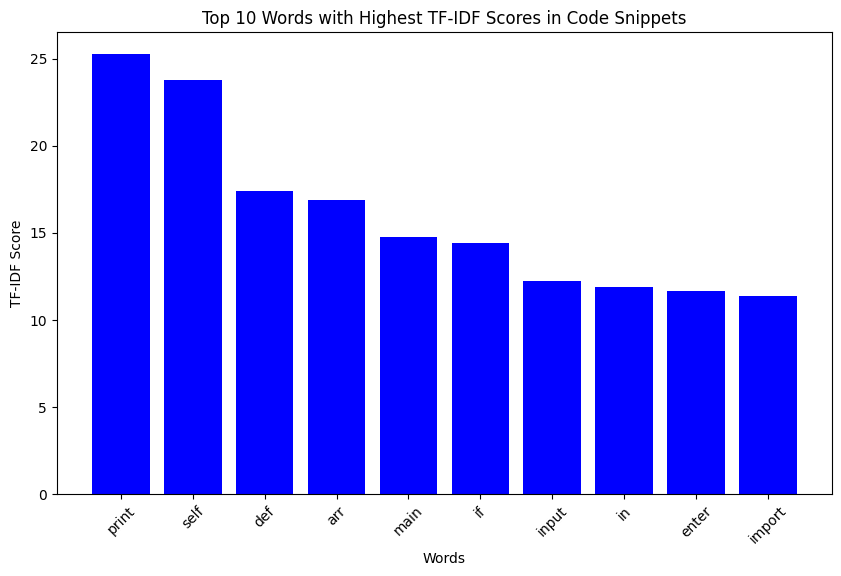

In [9]:
# TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['code'])


#---------------------------------------------------#
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Display the shape of the transformed data
print("Shape of X_tfidf:", X_tfidf.shape)

# Get the feature names (words)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores of each word in the corpus
tfidf_scores = np.asarray(X_tfidf.sum(axis=0)).flatten()

# Create a DataFrame for the TF-IDF scores
tfidf_score_df = pd.DataFrame({'word': tfidf_feature_names, 'score': tfidf_scores})

# Display the first few rows of the TF-IDF score DataFrame
print("\nTF-IDF Scores:\n")
print(tfidf_score_df.head())

# Sort the DataFrame by score in descending order
tfidf_score_df = tfidf_score_df.sort_values(by='score', ascending=False)

# Display the top 10 words with highest TF-IDF scores
print("\nTop 10 Words with Highest TF-IDF Scores:\n")
print(tfidf_score_df.head(10))

# Plot the top 10 words with highest TF-IDF scores
plt.figure(figsize=(10, 6))
plt.bar(tfidf_score_df['word'].head(10), tfidf_score_df['score'].head(10), color='blue')
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 10 Words with Highest TF-IDF Scores in Code Snippets')
plt.xticks(rotation=45)
plt.show()


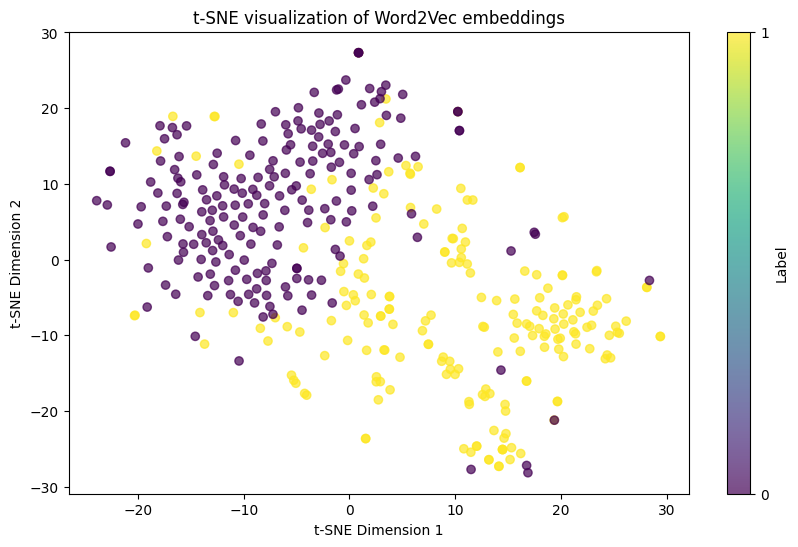

In [10]:
# Load pre-trained Word2Vec model from gensim
word2vec_model = api.load('word2vec-google-news-300')

# Calculate Word2Vec Embeddings
def get_word2vec_vector(text):
    tokens = text.split()
    vectors = [word2vec_model[token] for token in tokens if token in word2vec_model]
    if len(vectors) == 0:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(vectors, axis=0)

# Transform codes with Word2Vec
X_word2vec = np.array([get_word2vec_vector(text) for text in data['code']])

#---------------------------------#
# Import necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_word2vec)

# Add the t-SNE components to the DataFrame
data['tsne-2d-one'] = X_tsne[:,0]
data['tsne-2d-two'] = X_tsne[:,1]

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['tsne-2d-one'], data['tsne-2d-two'], c=data['label'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE visualization of Word2Vec embeddings')
plt.colorbar(scatter, ticks=[0, 1], label='Label')
plt.show()


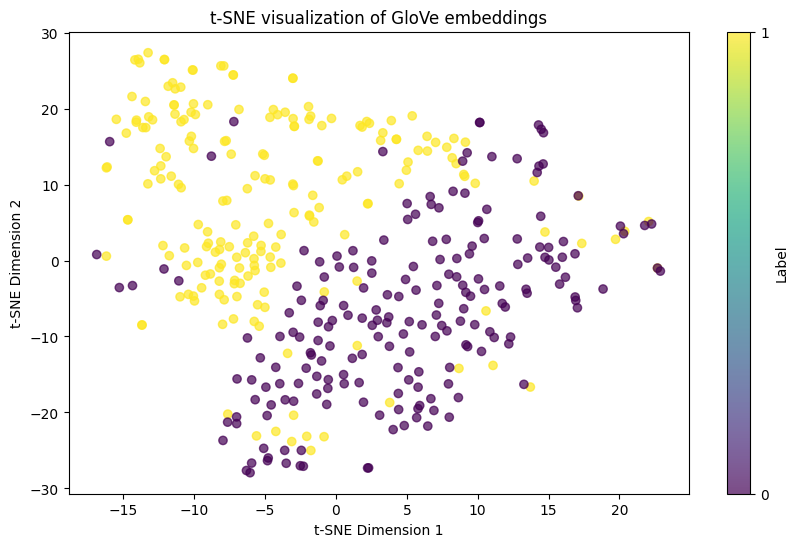

In [11]:
# Load spaCy model for GloVe
nlp = spacy.load('en_core_web_md')

# Calculate GloVe Embeddings using spaCy
def get_spacy_vector(text):
    doc = nlp(text)
    return doc.vector

# Transform codes with GloVe
X_glove = np.array([get_spacy_vector(text) for text in data['code']])


#---------------------------------#
# Import necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne_glove = tsne.fit_transform(X_glove)

# Add the t-SNE components to the DataFrame
data['tsne-glove-2d-one'] = X_tsne_glove[:,0]
data['tsne-glove-2d-two'] = X_tsne_glove[:,1]

# Plot the t-SNE results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data['tsne-glove-2d-one'], data['tsne-glove-2d-two'], c=data['label'], cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE visualization of GloVe embeddings')
plt.colorbar(scatter, ticks=[0, 1], label='Label')
plt.show()


In [12]:
# Convert Word2Vec and GloVe arrays to sparse matrices for compatibility with hstack
X_word2vec_sparse = csr_matrix(X_word2vec)
X_glove_sparse = csr_matrix(X_glove)


In [13]:
# Combine all features
X_combined = hstack([X_bow, X_tfidf, X_word2vec_sparse, X_glove_sparse])




In [14]:
# Splitting the data
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=0)

## Model Training & Evaluation

In [15]:
# Run different models to compare
def run_exps(X_train, y_train, X_test, y_test):
    dfs = []
    results = []
    names = []
    # Define which models to test
    models = [
          ('Logistic Regression', LogisticRegression(penalty='l2', C=1.0)),
          ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')),
          ('Support Vector Machine', SVC(C=1.0, kernel='rbf')),
          ('KNN', KNeighborsClassifier(n_neighbors=5)),
          ('CatBoost', CatBoostClassifier(verbose=False, l2_leaf_reg=3.0, random_strength=1.0)),
          ('Bagging', BaggingClassifier(DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1), n_estimators=10)),
          ('XGB', XGBClassifier(reg_alpha=30, reg_lambda=1.0))
        ]

    # Specify scoring metrics and labels
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    target_names = ['Human', 'AI']

    # Iterate through all models
    for name, model in models:
        # Do 5 fold cross validation
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        # Fit the model
        clf = model.fit(X_train, y_train)
        # Make predictions
        y_pred = clf.predict(X_test)
        print(name)
        # Print classification repot
        print(classification_report(y_test, y_pred, target_names=target_names))
        # Append to the results
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    return final
    
final = run_exps(X_train, y_train, X_test, y_test)

Logistic Regression
              precision    recall  f1-score   support

       Human       0.89      0.89      0.89        45
          AI       0.91      0.91      0.91        55

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Random Forest
              precision    recall  f1-score   support

       Human       0.90      0.96      0.92        45
          AI       0.96      0.91      0.93        55

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Support Vector Machine
              precision    recall  f1-score   support

       Human       0.89      0.93      0.91        45
          AI       0.94      0.91      0.93        55

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg     

Text(0.5, 1.0, 'Comparison of Model by Classification Metric')

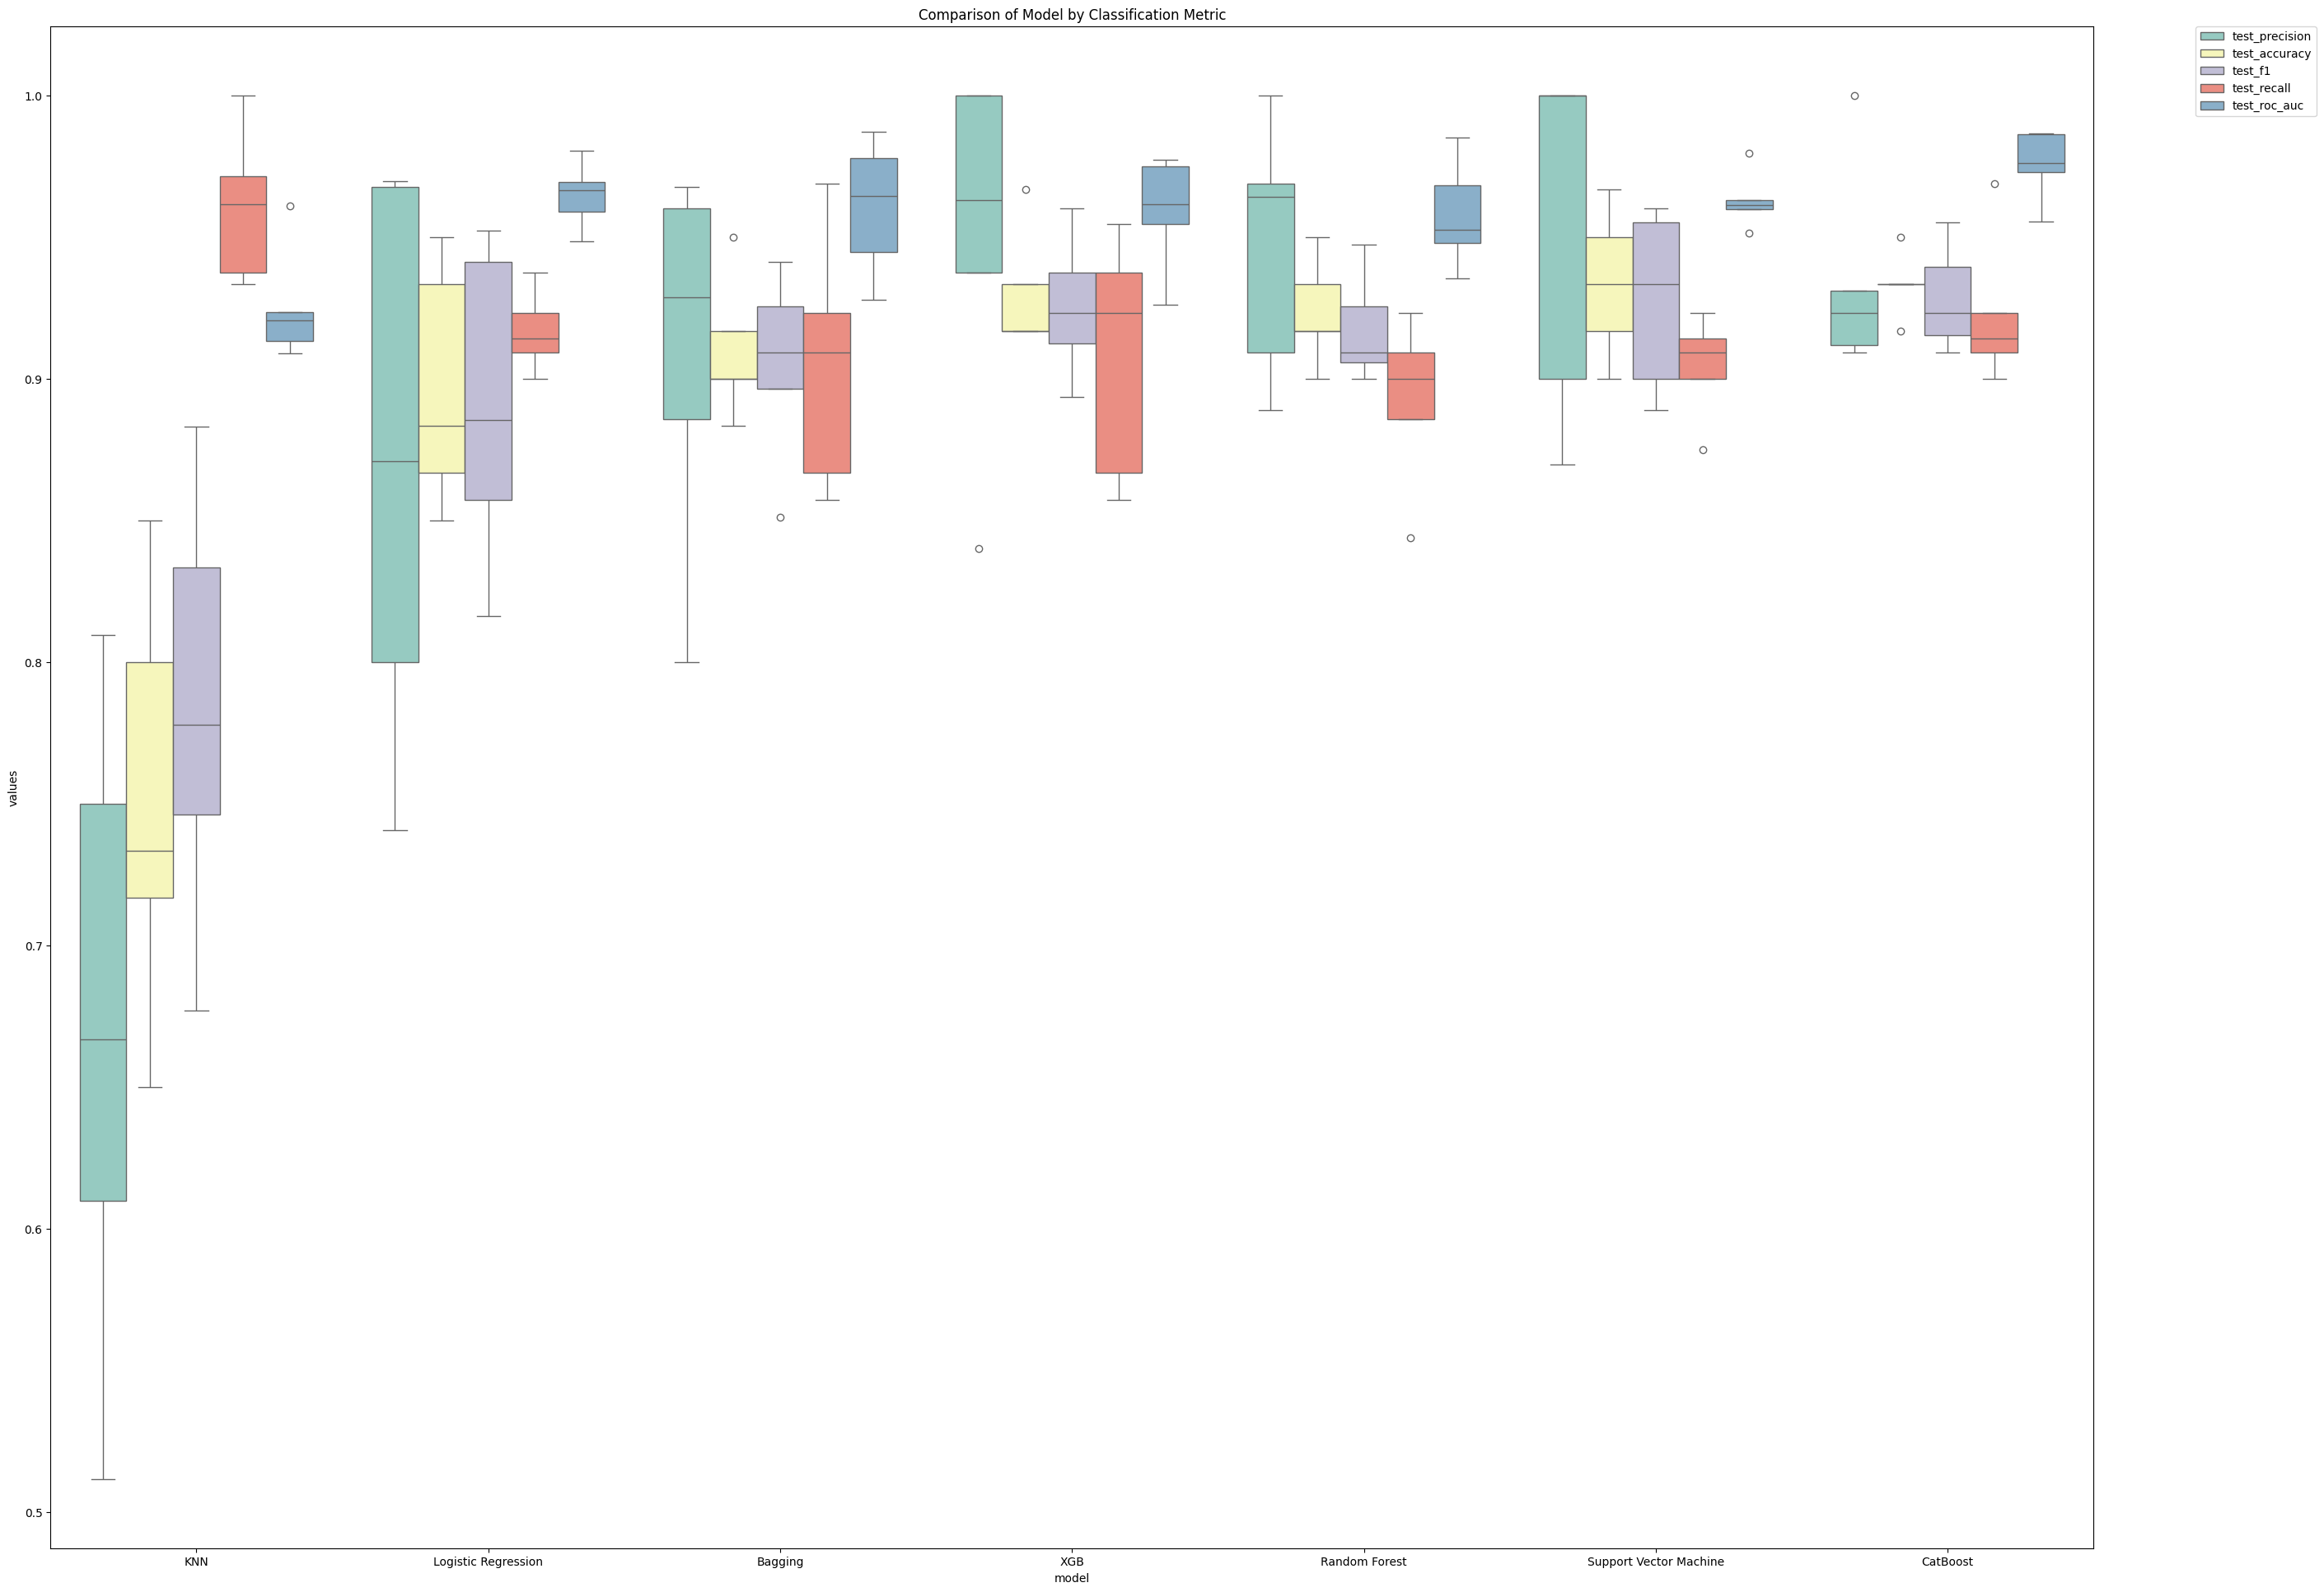

In [16]:
# Pivot the table
results_long = pd.melt(final, id_vars=['model'], var_name='metrics', value_name='values')

# Fit time metrics
time_metrics = ['fit_time','score_time'] 

# Get data without fit
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] 
results_long_nofit = results_long_nofit.sort_values(by='values')

# Plot metrics for different models
plt.figure(figsize=(32, 24))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')

In [17]:
# Calculate highest f1-score
best_model = final.groupby('model')['test_f1'].mean().idxmax()
print(f"Recommended Model: {best_model}")

Recommended Model: CatBoost


In [18]:
# Run CatBoostClassifier
model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

              precision    recall  f1-score   support

       Human       0.86      0.96      0.91        45
          AI       0.96      0.87      0.91        55

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.92      0.91      0.91       100



Logistic Regression
Train Classification Report
              precision    recall  f1-score   support

       Human       0.99      1.00      0.99       155
          AI       1.00      0.99      0.99       145

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Test Classification Report
              precision    recall  f1-score   support

       Human       0.89      0.89      0.89        45
          AI       0.91      0.91      0.91        55

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

Random Forest
Train Classification Report
              precision    recall  f1-score   support

       Human       0.99      1.00      1.00       155
          AI       1.00      0.99      1.00       145

    accuracy                           1.00       300
   macro av

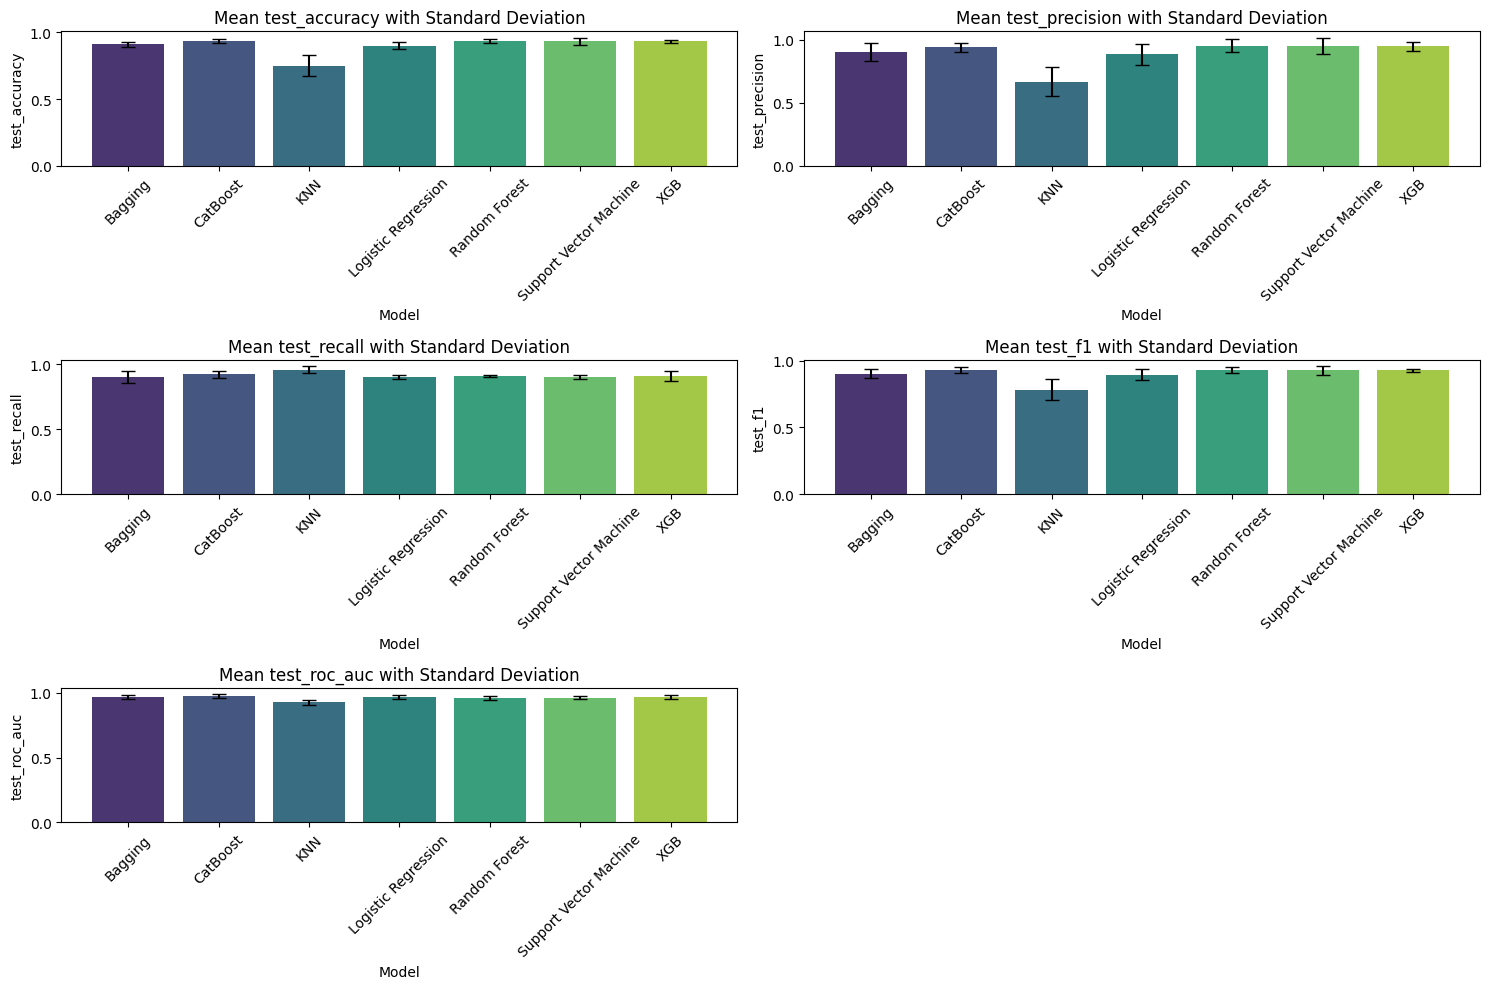

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to run experiments with different models and check for overfitting
def run_exps(X_train, y_train, X_test, y_test):
    dfs = []
    results = []
    names = []
    # Define which models to test
    models = [
          ('Logistic Regression', LogisticRegression(C=0.1)),
          ('Random Forest', RandomForestClassifier(n_estimators=100, max_depth=10)),
          ('Support Vector Machine', SVC(C=1.0)),
          ('KNN', KNeighborsClassifier(n_neighbors=5)),
          ('CatBoost', CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=False)),
          ('Bagging', BaggingClassifier(DecisionTreeClassifier(), n_estimators=20)),
          ('XGB', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1))
        ]

    # Specify scoring metrics and labels
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    target_names = ['Human', 'AI']

    # Iterate through all models
    for name, model in models:
        # Do 5 fold cross validation
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        # Fit the model
        clf = model.fit(X_train, y_train)
        # Make predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
        print(name)
        # Print classification report for train and test data
        print("Train Classification Report")
        print(classification_report(y_train, y_pred_train, target_names=target_names))
        print("Test Classification Report")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        # Append to the results
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    return final

# Assuming X_train, y_train, X_test, y_test are already defined
final = run_exps(X_train, y_train, X_test, y_test)

# Visualize the results
final_grouped = final.groupby('model').agg(['mean', 'std']).reset_index()

metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(3, 2, i+1)
    sns.barplot(x='model', y=(metric, 'mean'), data=final_grouped, palette='viridis', ci=None)
    plt.errorbar(x=final_grouped['model'], y=final_grouped[(metric, 'mean')], 
                 yerr=final_grouped[(metric, 'std')], fmt='none', c='black', capsize=5)
    plt.title(f'Mean {metric} with Standard Deviation')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [20]:
from keras.models import Sequential
from keras.layers import Dense

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")



Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7044 - loss: 0.5517 - val_accuracy: 0.8800 - val_loss: 0.2946
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9398 - loss: 0.1772 - val_accuracy: 0.9000 - val_loss: 0.2428
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9590 - loss: 0.0953 - val_accuracy: 0.9200 - val_loss: 0.2916
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9627 - loss: 0.0746 - val_accuracy: 0.8900 - val_loss: 0.2760
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9806 - loss: 0.0399 - val_accuracy: 0.8700 - val_loss: 0.2883
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9965 - loss: 0.0232 - val_accuracy: 0.9200 - val_loss: 0.2765
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9753 - loss: 0.0557 - val_accuracy: 0.9200 - val_loss: 0.3097
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9769 - loss: 0.0583 - val_accuracy: 0.9100 - v

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4837 - loss: 0.7724 - val_accuracy: 0.8200 - val_loss: 0.5168
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7227 - loss: 0.5310 - val_accuracy: 0.8700 - val_loss: 0.4143
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7889 - loss: 0.4207 - val_accuracy: 0.9100 - val_loss: 0.3269
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8398 - loss: 0.4122 - val_accuracy: 0.8500 - val_loss: 0.3123
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9118 - loss: 0.2617 - val_accuracy: 0.8800 - val_loss: 0.2596
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9554 - loss: 0.2009 - val_accuracy: 0.9300 - val_loss: 0.2345
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9192 - loss: 0.2230 - val_accuracy: 0.8800 - val_loss: 0.2387
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9213 - loss: 0.1625 - val_accuracy: 0.9200 - v

In [22]:
import torch
from transformers import BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch.nn as nn

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, num_classes):
        super(TransformerModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return logits

# Load the data and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
input_ids = []
attention_masks = []
labels = data['label'].tolist()

for text in data['code']:
    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2, random_state=42)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids, test_size=0.2, random_state=42)

# Create the model instance
model = TransformerModel(num_classes=2)
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 5
batch_size = 16

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        masks = train_masks[i:i+batch_size].to(device)
        labels = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        logits = model(inputs, masks)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted_labels = torch.max(logits, 1)
        train_acc += (predicted_labels == labels).sum().item()

    train_loss /= len(X_train)
    train_acc /= len(X_train)

    # Evaluation
    model.eval()
    eval_loss = 0.0
    eval_acc = 0.0
    predictions = []

    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size].to(device)
            masks = test_masks[i:i+batch_size].to(device)
            labels = y_test[i:i+batch_size].to(device)

            logits = model(inputs, masks)
            loss = loss_fn(logits, labels)

            eval_loss += loss.item()
            _, predicted_labels = torch.max(logits, 1)
            eval_acc += (predicted_labels == labels).sum().item()

            predictions.extend(predicted_labels.cpu().numpy())

    eval_loss /= len(X_test)
    eval_acc /= len(X_test)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Eval Loss: {eval_loss:.4f} | Eval Accuracy: {eval_acc:.4f}")

# Classification report
target_names = ['Human', 'AI']
y_true = y_test.cpu().numpy()
print(classification_report(y_true, predictions, target_names=target_names))

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch 1/5
Train Loss: 0.0302 | Train Accuracy: 0.8125
Eval Loss: 0.0183 | Eval Accuracy: 0.9250
Epoch 2/5
Train Loss: 0.0135 | Train Accuracy: 0.9531
Eval Loss: 0.0124 | Eval Accuracy: 0.9250
Epoch 3/5
Train Loss: 0.0094 | Train Accuracy: 0.9531
Eval Loss: 0.0114 | Eval Accuracy: 0.9375
Epoch 4/5
Train Loss: 0.0075 | Train Accuracy: 0.9563
Eval Loss: 0.0083 | Eval Accuracy: 0.9625
Epoch 5/5
Train Loss: 0.0060 | Train Accuracy: 0.9594
Eval Loss: 0.0088 | Eval Accuracy: 0.9500
              precision    recall  f1-score   support

       Human       0.94      0.94      0.94        36
          AI       0.95      0.95      0.95        44

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80

